In [1]:
import pandas as pd
import numpy as np
import random
from random import randrange
import time
import os
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import itertools
from itertools import permutations
from itertools import combinations
from itertools import chain

import multiprocessing
from multiprocessing import Process
from multiprocessing import Pool

import cProfile
import pstats
import io
from pstats import SortKey
from functools import wraps

from copy import deepcopy

import json

# https://www.redblobgames.com/grids/circle-drawing/

In [2]:
def export_to_json(data, filename):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data exported to {filename}")


def import_from_json(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
    return data



In [3]:
import perm_act_functions
import perm_act_world_states

In [4]:
from perm_act_functions import adjacent_locations, chebyshev_distance, bresenham_line, calculate_full_path, check_opportunity_attacks, is_line_of_sight_clear, check_visibility
from perm_act_world_states import world, world_grid_states

In [5]:
# statistics and probabilities
# chance to hit = (21 + Attack Bonus - Target AC) / 20
# chance to hit disadvantage = (21 + Attack Bonus - Target AC)^2 / 400
# chance to hit advantage = 1 - (Target AC - Attack Bonus - 1)^2 / 400


In [6]:
class entity:
    def __init__(self,world):
        self.world = world
        self.is_spawned = False

        self.caster = False
        self.concentrating = False
        self.concentration = False

        self.attack_limit = 1
        self.weapon_equipped = []
        self.equipped_armor = []
        self.inventory = []

        self.ac = 10
        self.hp = 1
        self.conditions = []

        self.circumstances = {}

        self.spells = {}

        if self.is_spawned == False:
            self.location = [0,0]
            
        elif self.is_spawned == True:
            x_loc = world.grid[np.where(world.grid[:,0] == max(world.grid))]
            print('x: ',x_loc)
            y_loc = world.grid[np.where(world.grid[0,:] == max(world.grid))]
            print('y: ',y_loc)
            self.location = [x_loc,y_loc]

        self.speed = 6
        self.coins = 0

        # will need to have a add_entity() in order to add a key: value pair to circumstances per enemy in world


c:\Users\maxhi\OneDrive\Documents\GitHub\5e-Simulation\perm_act_world_states.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


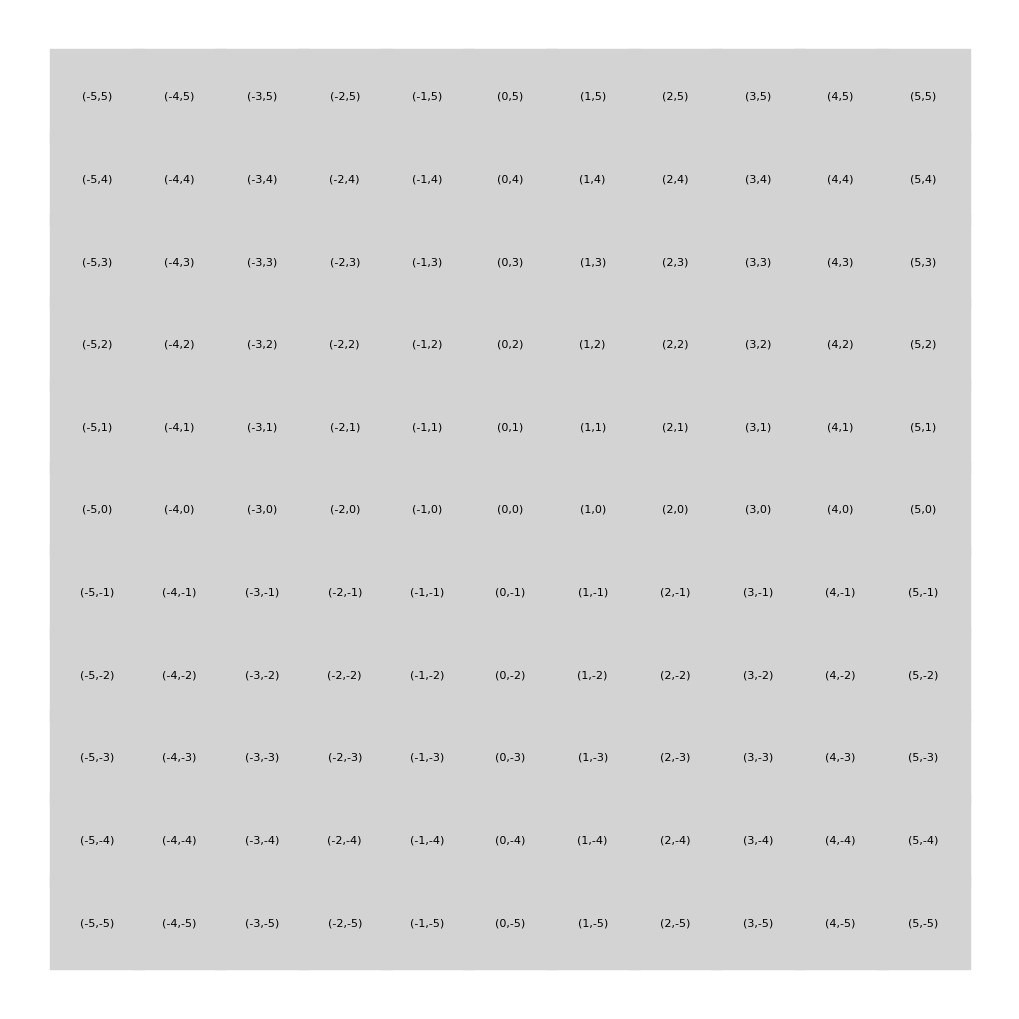

In [7]:
stage = world(11)
stage.generate_map()
actor = entity(stage)
stage.visualize()

In [8]:
class RuleBasedSequenceDFS:
    def __init__(self, min_length, max_length, start, end, rules, acting_entity):
        self.min_length = min_length
        self.max_length = max_length
        self.start = start
        self.end = end
        self.rules = rules
        self.sequences = []
        self.acting_entity = acting_entity

    def check_rules(self, sequence, next_num, acting_entity):
        # Apply all rules to the current sequence and next number
        return all(rule(sequence, next_num, acting_entity) for rule in self.rules)

    def dfs(self, current_sequence):
        # Check if the current sequence is within the desired length range
        if self.min_length <= len(current_sequence) <= self.max_length:
            self.sequences.append(current_sequence.copy())
        
        # Continue exploring if we haven't reached the maximum length
        if len(current_sequence) < self.max_length:
            for next_num in range(self.start, self.end + 1):
                if self.check_rules(current_sequence, next_num, self.acting_entity):
                    current_sequence.append(next_num)
                    self.dfs(current_sequence)
                    current_sequence.pop()  # Backtrack


    def generate_sequences(self):
        self.dfs([])
        return self.sequences
    


In [9]:
# Example rules
def rule_increasing(sequence, next_num):
    return not sequence or next_num > sequence[-1]

def rule_even_sum(sequence, next_num):
    return sum(sequence + [next_num]) % 2 == 0

def rule_no_consecutive(sequence, next_num):
    return not sequence or abs(next_num - sequence[-1]) > 1

def rule_prime_sum(sequence, next_num):
    def is_prime(n):
        if n < 2:
            return False
        for i in range(2, int(n**0.5) + 1):
            if n % i == 0:
                return False
        return True
    return is_prime(sum(sequence + [next_num]))

In [10]:
subaction_dict = {
    '0': 'Move_One',                # needs a target
    '1': 'Move_Two',
    '2': 'Move_Three',
    '3': 'Move_Four',
    '4': 'Object (Free)',      # needs a target
    '5': 'Attack',              # needs a target
    '6': 'Dodge',
    '7': 'Object',              # needs a target
    '8': 'Disengage',
    '9': 'Hide',
    '10': 'Help',
    '11': 'Cast',
    '12': 'Dash',
    '13': 'Don or Doff Shield',
    '14': 'End Concentration',
    #'15': 'Off Hand Weapon Attack',

}

move_subactions = [0,1,2,3]
    # go prone
    # stand up

action_subactions = [5,6,7,8,9,10,11,12,13]
attack_subactions = [5]
free_subactions = [4,14]               # End Concentration will go here as well
bonus_subactions = [15]

subactions_req_targets = [0,1,2,3,4,5,7,15]

theoretical_turn_length = len(free_subactions) + 6 + 1 + 1

# rules
# - only one action
def rule_only_one_action(sequence, next_num, acting_entity):
    count = sum(1 for num in sequence if num in action_subactions)
    return count == 0 or (count == 1 and next_num not in action_subactions)

def rule_only_one_bonus_action(sequence, next_num, acting_entity):
    count = sum(1 for num in sequence if num in bonus_subactions)
    return count == 0 or (count == 1 and next_num not in bonus_subactions)

def rule_no_consecutive_zeros(sequence, next_num, acting_entity):
    if next_num == 0 and (not sequence or sequence[-1] == 0):
        return False
    return True

def rule_no_consecutive_ones(sequence, next_num, acting_entity):
    if next_num == 1 and (not sequence or sequence[-1] == 1):
        return False
    return True

def rule_no_consecutive_twos(sequence, next_num, acting_entity):
    if next_num == 2 and (not sequence or sequence[-1] == 2):
        return False
    return True

def rule_no_consecutive_zero_and_ones(sequence, next_num, acting_entity):
    if next_num == 0 and (not sequence or sequence[-1] == 1):
        return False
    return True

def rule_no_consecutive_one_and_twos(sequence, next_num, acting_entity):
    if next_num == 1 and (not sequence or sequence[-1] == 2):
        return False
    return True

def rule_no_consecutive_one_and_twos(sequence, next_num, acting_entity):
    if next_num == 1 and (not sequence or sequence[-1] == 2):
        return False
    return True

def rule_limit_move_points(sequence, next_num, acting_entity):
    move_points = {0: 1, 1: 2, 2: 3, 3: 4}
    current_points = sum(move_points.get(num, 0) for num in sequence)
    if next_num in move_points:
        current_points += move_points[next_num]
    return current_points <= 6    

def rule_limit_move_actions(sequence, next_num, acting_entity):
    count = sum(1 for num in sequence if num in move_subactions)
    if next_num in move_subactions:
        count += 1
    return count <= 6

def rule_one_of_each_free_action(sequence, next_num, acting_entity):
    if next_num in free_subactions:
        return next_num not in sequence
    return True

def rule_shield(sequence, next_num, acting_entity):
    if next_num == 13 and 'shield' not in acting_entity.inventory or next_num == 13 and 'shield' not in acting_entity.equipped_armor:
        return False
    return True

def rule_concentration(sequence, next_num, acting_entity):
    if next_num == 14 and acting_entity.concentration == False:
        return False
    return True

def rule_help_alone(sequence, next_num, acting_entity):
    if next_num == 10 and acting_entity.world.non_enemies == []:
        return False
    return True

def rule_off_hand_two_weapons_requirement(sequence, next_num, acting_entity):
    if next_num == 15 and len(acting_entity.weapon_equipped) < 2:
        return False
    return True


rules = [rule_only_one_action, 
         rule_only_one_bonus_action, 
         rule_no_consecutive_zeros, 
         rule_no_consecutive_ones,
         rule_no_consecutive_zero_and_ones,
         rule_no_consecutive_one_and_twos,
         rule_limit_move_points,
         rule_limit_move_actions,
         rule_one_of_each_free_action,
         rule_shield,
         rule_concentration,
         rule_help_alone,
         rule_off_hand_two_weapons_requirement
         ]



# Generate sequences of length 3, with numbers from 1 to 15, with no consecutive numbers and prime sum
sequence_generator = RuleBasedSequenceDFS(min_length=0,max_length=theoretical_turn_length, start=0, end=len(subaction_dict), rules=rules, acting_entity=actor)
action_series_full_list = sequence_generator.generate_sequences()



def precalc_reward(action_series, entity):
    reward_value = 0

    # if an item from action_subactions is in action_series:
    if any(item in action_subactions for item in action_series):
        reward_value += 1

    # attacks being made
    if 5 in action_series and 15 in action_series:
        reward_value += 2

    if entity.location in entity.world.enemy_adjacent_locations and 8 not in action_series and any(0 in action_series or 1 in action_series or 2 in action_series or 3 in action_series):
        reward_value -= 1
    


    return reward_value

reward_series_full_list = [precalc_reward(i, actor) for i in action_series_full_list]


In [11]:
print(len(action_series_full_list))
action_series_full_list

1730


[[],
 [2],
 [2, 0],
 [2, 0, 1],
 [2, 0, 1, 4],
 [2, 0, 1, 4, 5],
 [2, 0, 1, 4, 6],
 [2, 0, 1, 4, 7],
 [2, 0, 1, 4, 8],
 [2, 0, 1, 4, 9],
 [2, 0, 1, 4, 11],
 [2, 0, 1, 4, 12],
 [2, 0, 1, 5],
 [2, 0, 1, 5, 4],
 [2, 0, 1, 6],
 [2, 0, 1, 6, 4],
 [2, 0, 1, 7],
 [2, 0, 1, 7, 4],
 [2, 0, 1, 8],
 [2, 0, 1, 8, 4],
 [2, 0, 1, 9],
 [2, 0, 1, 9, 4],
 [2, 0, 1, 11],
 [2, 0, 1, 11, 4],
 [2, 0, 1, 12],
 [2, 0, 1, 12, 4],
 [2, 0, 4],
 [2, 0, 4, 0],
 [2, 0, 4, 0, 5],
 [2, 0, 4, 0, 5, 0],
 [2, 0, 4, 0, 6],
 [2, 0, 4, 0, 6, 0],
 [2, 0, 4, 0, 7],
 [2, 0, 4, 0, 7, 0],
 [2, 0, 4, 0, 8],
 [2, 0, 4, 0, 8, 0],
 [2, 0, 4, 0, 9],
 [2, 0, 4, 0, 9, 0],
 [2, 0, 4, 0, 11],
 [2, 0, 4, 0, 11, 0],
 [2, 0, 4, 0, 12],
 [2, 0, 4, 0, 12, 0],
 [2, 0, 4, 1],
 [2, 0, 4, 1, 5],
 [2, 0, 4, 1, 6],
 [2, 0, 4, 1, 7],
 [2, 0, 4, 1, 8],
 [2, 0, 4, 1, 9],
 [2, 0, 4, 1, 11],
 [2, 0, 4, 1, 12],
 [2, 0, 4, 5],
 [2, 0, 4, 5, 0],
 [2, 0, 4, 5, 1],
 [2, 0, 4, 6],
 [2, 0, 4, 6, 0],
 [2, 0, 4, 6, 1],
 [2, 0, 4, 7],
 [2, 0, 4, 7, 0],
 [2, 0, 

In [12]:
reward_series_full_list

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
stage = world(10)
stage.generate_map()
actor = entity(stage)
stage.add_enemy((1,1))
stage.add_enemy((-2,0))
stage.add_enemy((0,3))

stage.add_coin((3,0))
stage.add_coin((-1,-1))

In [ ]:
stage.enemies[0]

In [ ]:
# lets create the power set for action_series

subaction_dict = {
    '0': 'Move_One',                # needs a target
    '1': 'Move_Two',
    '2': 'Move_Three',
    '3': 'Move_Four',
    '4': 'Object (Free)',      # needs a target
    '5': 'Attack',              # needs a target
    '6': 'Dodge',
    '7': 'Object',              # needs a target
    '8': 'Disengage',
    #'9': 'Hide',
    #'10': 'Help',
    #'11': 'Cast',
    #'12': 'Dash',
    #'13': 'Shield',
    #'14': 'End Concentration',
    #'15': 'Off Hand Weapon Attack',

}

entity.subaction_options_dict = subaction_dict

    # help - need to choose 1) what type of help 2) target
    # cast - need to choose 1) which spell  (and others)     2) target
    # dash - need to be able to add new spaces to the location_series...
    # don or doff shield... 
    # escape grapple
    # grapple - need to choose target, attack_subaction
    # search
    # shove - need to choose 1) target 2) prone OR knockback, attack_subaction
    # stabilize creature
    # waking someone
    
    # optional rule: Action Options 
        # Disarm
        # Overrun
        # Shove Aside
        # Tumble
        # 

move_subactions = [0,1,2,3]
    # go prone
    # stand up

action_subactions = [5,6,7,8,9,10,11,12,13]
attack_subactions = [5]
free_subactions = [4,14]               # End Concentration will go here as well
bonus_subactions = [15]

subactions_req_targets = [0,1,2,3,4,5,7,15]


# how I'll have to do Cast action, 
# it'll probably require another dictionary...
# 
# I may need another dictionary for Cast, Dash, Object, 



def generate_turns(entity):
    all_action_series = []
    theoretical_turn_length = len(free_subactions) + 6 + 1 + 1

    for length in range(1, 9):  # Turns can be 1 to 8 actions long: 6 Moves, 1 Object Interaction, 1 Action
                                        # new problem: they can contain any number of unique free actions...
        for turn in itertools.product(range(len(subaction_dict.keys())), repeat=length):
            if validate_turn(turn,entity):
                yield turn
    
    return list(all_action_series)


def validate_turn(turn,entity):
    # options 0, 1, and 2 are now Move Variants
    # a player can only move 6 times in a turn
    # 0 uses 1 move, 1 uses 2 moves, 2 uses 3 moves
    # options 3 and 8 are now Object Interactions
    
    move_count = 0
    individual_move_count = 0
    object_interact_count = 0
    action_count = 0
    bonus_action_count = 0
    attack_count = 0


    for action in turn:
        if action == 0:
            move_count += 1
            individual_move_count += 1

        if action == 1:
            move_count += 2
        
        if action == 2:
            move_count += 3
        
        if action == 3:
            move_count += 4

        if action in [4, 7]:
            object_interact_count += 1
        
        if action in action_subactions:
            action_count += 1
        
        if action in bonus_subactions:
            bonus_action_count += 1

        if action in attack_subactions:
            attack_count += 1

    return (move_count <= 6 and 
            individual_move_count <= 3 and
            object_interact_count <= (2 if 7 in turn else 1) and 
            action_count <= 1 and 
            bonus_action_count <= 1 and 
            attack_count <= entity.attack_limit)

def remove_redundant_turns(entity):
    turns = generate_turns(entity)
    solid_turns = list(turns)

    # what types of moves are redundant?
    # any combo that contains either 3 or 6 but not both and is otherwise the same is redundant
    # first, lets create a list of all the unique permutations
    #turns = turns
    # then, lets create a list of all the permutations that contain either 3 or 6
    #object_interact_turns = [turn for turn in turns if 3 in turn and 6 not in turn or 6 in turn and 3 not in turn]
    # any permutations that are the same other than 3 and 6 should be isolated
    #object_interact_turns = [turn for turn in object_interact_turns if turn not in [x for x in turns if x not in object_interact_turns]]
    
    # then I only need to keep one of the two
    #for turn in object_interact_turns:
    #    if 3 in turn:
    #        turns.remove([x for x in turns if 6 in x and x != turn][0])
    #    elif 6 in turn:
    #        turns.remove([x for x in turns if 3 in x and x != turn][0])

    # any turns that contain three adjacent 0s, two adjacent 0s, or a 0 and a 1 are redundant
    turns_to_remove = []

    for turn in solid_turns:
        adjacent_0_count = 0
        adjacent_1_count = 0
        adjacent_0_1_count = 0
        adjacent_0_2_count = 0
        adjacent_1_2_count = 0

        for i in range(len(turn)-1):
            
            if turn[i] == 0 and turn[i+1] == 0:
                adjacent_0_count += 1
            
            if turn[i] == 1 and turn[i+1] == 1:
                adjacent_1_count += 1
            
            if turn[i] == 0 and turn[i+1] == 1 or turn[i] == 1 and turn[i+1] == 0:
                adjacent_0_1_count += 1
            
            if turn[i] == 0 and turn[i+1] == 2 or turn[i] == 2 and turn[i+1] == 0:
                adjacent_0_2_count += 1

            if turn[i] == 1 and turn[i+1] == 2 or turn[i] == 2 and turn[i+1] == 1:
                adjacent_1_2_count += 1

        if adjacent_0_count > 0:
            turns_to_remove.append(turn)
        if adjacent_1_count > 0:
            turns_to_remove.append(turn)
        if adjacent_0_1_count > 0:
            turns_to_remove.append(turn)
        if adjacent_0_2_count > 0:
            turns_to_remove.append(turn)
        if adjacent_1_2_count > 0:
            turns_to_remove.append(turn)

    # remove duplicates in turns_to_remove
    turns_to_remove = list(set(turns_to_remove))

    for turn in turns_to_remove:
        solid_turns.remove(turn)

    return solid_turns



def choose_turn(entity):
    non_reduntant_turns = remove_redundant_turns(entity)
    all_action_series = {i:turn for i,turn in enumerate(non_reduntant_turns) if validate_turn(turn,entity)}
    print(len(all_action_series))
    return all_action_series

In [ ]:
def apply_permutations_to_location_series3(entity, action_series_dict, location_series_dict, one_space_permutations, two_space_permutations, three_space_permutations, four_space_permutations):
    # defining each element in the function:
    #   action_series                 - a set of numbers which each represent a sub-action an entity can take
    #   action_series_dict            - a dictionary containing all unique and legal action_series
    #   location_series               - a set of multiple (x,y) coordinates which represent the locations being targeted by the associated action_series
    #   permtuation_set               - the full power set of permutations of location_series, including illegal and illogical ones
    #   location_series_dict          - a dictionary containing all unique and legal location_series for the matching action_series from action_series_dict


    # what needs to happen in this function is for each action_series stored in action_series_dict,
    # each location_series in the appropriate permutation_set should be evaluated if it's appropriate for that action_series,
    # and if it meets all the criteria it should be stored in the location_series_dict
    # lastly, the function returns the finished location_series_dict


    # the current criteria that each location_series needs to meet:
    #   - the location_series must have the same number of locations as the associated action_series requires (i.e. length must match length)
    #   - the first location cannot be further away from the entity's starting position than the first move_action (either 1-4 spaces)
    #   - locations associated with the attack sub_action (currently represented by 5) cannot be more than 1 space away
    #   - locations associated with the attack sub_action cannot not be (or must be) in the enemy_locations list (because you can't target an empty space...yet)

    # the eventual criteria that each location_series should meet:
    #   - cannot move through obstructed spaces (requires cell states to be implemented)




    def determine_permutation_series(key, action_series, action_series_dict, one_space_permutations, two_space_permutations, three_space_permutations, four_space_permutations):
        # if the action_series contains 0 and not 1, 2, or 3, 
        # --and thus the entity is only moving a maximum of 1 space-- 
        # use one_space_permutations (the list of permutations for spaces within 1 space)
        
        if 0 in action_series_dict[key] and 1 not in action_series_dict[key] and 2 not in action_series_dict[key] and 3 not in action_series_dict[key]:
            permutation_set = one_space_permutations

        # if the action_series contains 1 and not 2 or 3, 
        # --and thus the entity is moving a maximum of 2 spaces--
        # then use two_space_permutations (the list of permutations for spaces within both 1 and 2 spaces)

        elif 1 in action_series_dict[key] and 2 not in action_series_dict[key] and 3 not in action_series_dict[key]:
            permutation_set = two_space_permutations

        # if the action_series contains 2 and not 3, 
        # --and thus the entity is moving a maximum of 3 spaces--
        # then use three_space_permutations (the list of permutations for spaces within 1, 2, and 3 spaces)

        elif 2 in action_series_dict[key] and 3 not in action_series_dict[key]:
            permutation_set = three_space_permutations

        # otherwise, use four_space_permutations
        else:
            permutation_set = four_space_permutations
        
        return permutation_set

    enemy_locations = entity.world.enemy_locations
    entity_location = entity.location
    coin_locations = entity.world.coin_locations

    for key, action_series in action_series_dict.items():

        permutation_set = determine_permutation_series(key, action_series, action_series_dict, one_space_permutations, two_space_permutations, three_space_permutations, four_space_permutations)
        number_of_locations_needed = sum(action_series.count(i) for i in subactions_req_targets)
        targeting_actions_only = list([x for x in action_series if x in subactions_req_targets])


        # first condition: length of location series must match length of number of locations needed
        filtered_permutation_set = [location_series for location_series in permutation_set if len(location_series) == number_of_locations_needed]
        

        for location_series in filtered_permutation_set:
            is_valid = True

            act_loc_zip = list(zip(targeting_actions_only,location_series))

            if act_loc_zip != []: # aka if there are locations being targeted

                # second condition: the first location cannot be distanced further away than allowable 
                if act_loc_zip[0][0] != 5 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > act_loc_zip[0][0] + 1:
                    is_valid = False
                    continue

                # second condition: the first location cannot be distanced further away than allowable 
                elif act_loc_zip[0][0] == 5 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > 1:
                    is_valid = False
                    continue

                # third condition: if the attack action is included, the associated location must be in enemy locations
                if act_loc_zip[0][0] == 5 and act_loc_zip[0][1] not in enemy_locations:
                    is_valid = False
                    continue


                # second condition: 
                if act_loc_zip[0][0] != 7 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > act_loc_zip[0][0] + 1:
                    is_valid = False
                    continue

                # second condition: the first location cannot be distanced further away than allowable 
                elif act_loc_zip[0][0] == 7 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > 1:
                    is_valid = False
                    continue

                # fourth condition: if object interaction (action) (7) is included, the associated location must be in coin_locations
                if act_loc_zip[0][0] == 7 and act_loc_zip[0][1] not in coin_locations or act_loc_zip[0][0] == 7 and act_loc_zip[0][1] != entity_location:
                    # using the object interaction action on the space the entity is in will be the shortcut for changing weapons...
                    is_valid = False
                    continue


                # second condition: 
                if act_loc_zip[0][0] != 4 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > act_loc_zip[0][0] + 1:
                    is_valid = False
                    continue

                # second condition: the first location cannot be distanced further away than allowable 
                elif act_loc_zip[0][0] == 4 and chebyshev_distance(entity_location, act_loc_zip[0][1]) > 1:
                    is_valid = False
                    continue

                # fourth condition: if object interaction (action) (7) is included, the associated location must be in coin_locations
                if act_loc_zip[0][0] == 4 and act_loc_zip[0][1] not in coin_locations or act_loc_zip[0][0] == 4 and act_loc_zip[0][1] != entity_location:
                    # using the object interaction action on the space the entity is in will be the shortcut for changing weapons...
                    is_valid = False
                    continue

                
                # if first action is hide, if the space is bright or dim light, not allowed
                if act_loc_zip[0][0] == 9:
                    if entity.world.grid2[entity_location[0]][entity_location[1]][3] in [0,1]:
                        is_valid = False
                        continue


                # can't take the cast action if not a caster
                if 11 in action_series and entity.caster == False:
                    is_valid = False
                    continue


                # can't don or doff a shield if they don't have one in their inventory
                if 13 in action_series and entity.inventory == []:
                    is_valid = False
                    continue


                # can't end concentration if you're not concentrating in the first place
                if 14 in action_series and entity.concentrating == False:
                    is_valid = False
                    continue

                # can't take a bonus action attack if you don't have two weapons in hand
                    # will need to change this so that it can be equipped mid-turn and still valid...
                if 15 in action_series and len(entity.weapon_equipped) != 2:
                    is_valid = False
                    continue

                # third condition: if the attack action is included, the associated location must be in enemy locations
                if act_loc_zip[0][0] == 15 and act_loc_zip[0][1] not in enemy_locations:
                    is_valid = False
                    continue

                # need an ally to help in order to take the help action
                if 10 in action_series and len(entity.world.non_enemies) == 0:
                    is_valid = False
                    continue


                if len(act_loc_zip) > 1:

                    if 5 in action_series:
                        # second condition: the first location cannot be distanced further away than allowable 
                        five_index = targeting_actions_only.index(5)
                        if five_index == 0:
                            if chebyshev_distance(entity_location, act_loc_zip[1][1]) > act_loc_zip[1][0] + 1:
                                is_valid = False
                                continue

                        if five_index > 0:
                            if chebyshev_distance(act_loc_zip[five_index - 1][1],act_loc_zip[five_index][1]) > 1:
                                is_valid = False
                                continue

                            if act_loc_zip[five_index][1] not in enemy_locations:
                                is_valid = False
                                continue

                    if 7 in action_series:
                        # fourth condition: if object interaction (action) (7) is included, the associated location must be in coin_locations
                        seven_index = targeting_actions_only.index(7)
                        if seven_index == 0:
                            if chebyshev_distance(entity_location, act_loc_zip[1][1]) > act_loc_zip[1][0] + 1:
                                is_valid = False
                                continue
                            
                            if seven_index > 0:
                                if chebyshev_distance(act_loc_zip[seven_index - 1][1],act_loc_zip[seven_index][1]) > 1:
                                    is_valid = False
                                    continue

                                if act_loc_zip[seven_index][1] not in coin_locations and act_loc_zip[0][1] != entity_location:
                                    is_valid = False
                                    continue

                    if 4 in action_series:
                        # fourth condition: if object interaction (action) (7) is included, the associated location must be in coin_locations
                        four_index = targeting_actions_only.index(4)
                        if four_index == 0:
                            if chebyshev_distance(entity_location, act_loc_zip[1][1]) > act_loc_zip[1][0] + 1:
                                is_valid = False
                                continue
                            
                            if four_index > 0:
                                if chebyshev_distance(act_loc_zip[four_index - 1][1],act_loc_zip[four_index][1]) > 1:
                                    is_valid = False
                                    continue

                                if act_loc_zip[four_index][1] not in coin_locations and act_loc_zip[0][1] != entity_location:
                                    is_valid = False
                                    continue


                    if 9 in action_series:
                        targeting_actions_only_plus_nine = list([x for x in action_series if x in subactions_req_targets or x == 9])
                        nine_index = targeting_actions_only_plus_nine.index(9)
                        # I need the last location prior to the 9 
                        # if the last location prior to the 9 is in Bright or Dim light, false
                        if nine_index > 0:
                            new_location_act = targeting_actions_only_plus_nine[nine_index-1]
                            new_location_act_index = targeting_actions_only.index(new_location_act)
                            new_location_loc = location_series[new_location_act_index]

                            if entity.world.grid2[new_location_loc[0]][new_location_loc[1]][3] in [0,1]:
                                is_valid = False
                                continue

                    if 10 in action_series:
                        # help action
                        pass




            if is_valid:
                location_series_dict[key].append(location_series)

    return location_series_dict



In [ ]:
def calc_reward_for_action_series_location_series_combo2(entity,eval_action_series,eval_location_series):
    reward = 0

    # I want a random 50 50 chance that +1 is added to reward to test if different values can be assigned to the reward lists
    #probability = 0.5
    #reward += (1 if random.random() < probability else 0)

    targeting_actions_only = list([x for x in eval_action_series if x in subactions_req_targets])
    act_loc_zip = list(zip(targeting_actions_only,eval_location_series))
    enemy_locations = entity.world.enemy_locations
    #coin_locations = entity.world.coin_locations
    
    enemy_adjacent_locations = []
    for enemy_location in enemy_locations:
        enemy_adjacent_locations.append(adjacent_locations(enemy_location))

    
    # - if the entity attacks a creature, rewarded
    if 5 in eval_action_series:
        reward += 1


    # if an attack would reduce the target to 0 hp, reward
    damage = 1
    #if 5 in eval_action_series:
    #    attack_index = targeting_actions_only.index(5)
    #    enemy_index = enemy_locations.index(act_loc_zip[attack_index][1])
    #    enemy_name = f'enemy_{enemy_index}'
    #    if enemy_name.hp - damage <= 0:
    #        reward += 2


    # - if movement prompts an opportunity attack, punished

    move_series_zip = [(act,loc) for act, loc in act_loc_zip if act in move_subactions]
    move_path = calculate_full_path(entity.location, move_series_zip)

    if 8 not in eval_action_series: # 8 being the disengage action
        if check_opportunity_attacks(move_path, enemy_locations, disengage_action=8):
            reward -= 1

    # - if the same locations are being passed over, punished slightly

    if len(move_path) != len(set(move_path)):
        reward -= 1

    
    # - if movement is unoptimal, punished slightly (triangle method using length of sides)
        # the idea is that because there are only a maximum of 3 move subactions taken, a triangle can be drawn
        # however, in order for something to be "optimal" it has to have a goal
        # that goal can be determined by the actions in the action_series such as attack or object interaction
            # so if there is a 5, a more optimal move_series gets closer to an enemy 
            # if there's a 4 or 7, a more optimal move_series gets closer to objects
    
    visibility = check_visibility(entity.location, enemy_locations, entity.world)
    if visibility:
        reward -= 1
    else:
        reward += 1


    # - if an action isn't taken, punished
    action_bool = [x for x in eval_action_series if x in action_subactions]
    if len(action_bool) < 1:
        reward -= 1
    else:
        reward += 1

    # - punish for the number of enemies that have clear line of sight of the entity

    # - punish for the number of opportunity attacks that are prompted
        # punish extra if flanked for any of those opportunity attacks


    # - punish if entity ends turn flanked by multiple enemies 
    

    return reward
    

In [ ]:
def calc_risk_for_act_loc_zip():
    pass

    # what does this function need to accomplish?
    

    # what are extra rewards/penalties that can't currently be calculated
    # - killing an enemy
    # - dealing more damage
    # - avoiding taking damage
    # - chance the enemy hits you

    # - expected damage 


In [ ]:
def calc_rewards_for_location_series2(entity, reward_series_dict, location_series_dict, action_series_dict):

    for key in action_series_dict.keys():
        reward_series_dict[key] = [calc_reward_for_action_series_location_series_combo2(entity,action_series_dict[key],location_series) for location_series in location_series_dict[key]]

    return reward_series_dict

In [ ]:
def create_object_dict(action_series, location_series):
    
    targeting_actions_only = list([x for x in action_series if x in subactions_req_targets])
    act_loc_zip = list(zip(targeting_actions_only,location_series))

    # the object permutations will need to include every object in the inventory, equipped enemy weapons, and coins

    # three ways to make this work:
    # - based on action_series_dict values
        # so for every action_series in the dict, if object interaction (4 or 7) are included in action_series, then generate a set of locations equal to the number of object interactions that are taken
    # - based on location_series_dict values
        # if an object is in the location
    # - based on location_series per action_series


    # what would the ideal output look like
        # well for an action_series [0,4,1,7,0],
        # and the multiple location_series could be 
        #   [
        #           (0,1),(0,3),(0,4)
        #   ] 
        # 

    # the object permutations will need to be filtered by removing objects out of reach
    all_objects = []
    objects_within_range = []

    # object permutations would be a length of 2 at most

    # which should come first AKA how should possible object choices be represented: numeric index in all_objects or location?
    
    # or how could zip() be used here?
        # I could create a zip_act_loc_obj
    object_only_action_series = list([x for x in action_series if x in [4,7]])
    move_only_series = [x for x in action_series if x in move_subactions]
    for i in object_only_action_series:
        # for 4 or 7 in the action series
        subaction_index = action_series.index(i)
        targeting_action_before_subaction_index = action_series[subaction_index - 1]
        


    

In [ ]:
def create_dash_dict(entity, action_series_dict, action_series, location_series):
    dash_permutations = []
    dash_dict = {x for x in action_series_dict}

    starting_location = 'placeholder' # this is where the entity is starting from 

In [ ]:
def create_cast_dict():
    pass

In [ ]:
def timing_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result
    return wrapper

@timing_decorator
def generate_location_series(entity):
    # I could do a move_one_locations, move_two_locations, move_three_locations, etc.
    # each would be a list of spaces within the Chebyshev distance of 1, 2, 3, etc.

    timing_results = {}
    imported_previous_dict_gen = False

    try:
        start_time = time.time()

        previous_dict_gen = import_from_json('previous_dict_gen.json')
        print(previous_dict_gen)

        end_time = time.time()
        timing_results['Importing previous_dict_gen'] = end_time - start_time

        imported_previous_dict_gen = True

    except:
        
        print('No previous_dict_gen.json available')

    if imported_previous_dict_gen == True:
        same_parameters_as_jsons = False

        start_time = time.time()
        print('subaction length: ', len(entity.subaction_options_dict))
        print('entity location: ', entity.location)
        
        Bypass = True
        if previous_dict_gen['entity_location'] == entity.location and previous_dict_gen['enemy_locations'] == entity.world.enemy_locations and previous_dict_gen['subaction_num'] == len(entity.subaction_options_dict) or Bypass == True:

            action_series_dict = import_from_json('action_series_dict.json')
            location_series_dict = import_from_json('location_series_dict.json')
            reward_series_dict = import_from_json('reward_series_dict.json')
            subaction_dict = import_from_json('subaction_dict.json')

            same_parameters_as_jsons = True
        else:
            if previous_dict_gen['entity_location'] == entity.location:
                print('location change')
            
            if previous_dict_gen['enemy_locations'] == entity.world.enemy_locations:
                print('enemy location change')
            
            if previous_dict_gen['subaction_num'] == len(entity.subaction_options_dict):
                print('new action options')

            print('Different parameters as last time')
            
        end_time = time.time()
        timing_results['Importing previous series_dicts'] = end_time - start_time

    if same_parameters_as_jsons == False:





        start_time = time.time()
        locations_within_range = []
        for x in range(-6,7):
            for y in range(-6,7):
                if chebyshev_distance(entity.location,(x,y)) <= 6:
                    locations_within_range.append((x,y))

        move_one_locations = []
        move_two_locations = []
        move_three_locations = []
        move_four_locations = []
        move_five_locations = []
        move_six_locations = []

        for location in locations_within_range:
            if chebyshev_distance(entity.location,location) <= 1:
                move_one_locations.append(location)
            if chebyshev_distance(entity.location,location) == 2:
                move_two_locations.append(location)
            if chebyshev_distance(entity.location,location) == 3:
                move_three_locations.append(location)
            if chebyshev_distance(entity.location,location) == 4:
                move_four_locations.append(location)
            if chebyshev_distance(entity.location,location) == 5:
                move_five_locations.append(location)
            if chebyshev_distance(entity.location,location) == 6:
                move_six_locations.append(location)



        end_time = time.time()
        timing_results['Generate and categorize locations'] = end_time - start_time
        start_time = time.time()
        ##### Now for Creating the Location Series #####
        # the most location targets I'll need in a single turn is now 4: moves 1-4 and attack
        # so I only need to create variations that are up to 4 long

        # what if instead of creating all the permutations, I did several based on distance

        # permutations within 1 space
        #one_space_permutations = list(itertools.permutations(move_one_locations,4))
        one_space_permutations = list(itertools.chain.from_iterable(combinations(move_one_locations, r) for r in range(0, 4)))
        print('One Space Locations: ',len(move_one_locations))
        print('One Space Permutations: ',len(one_space_permutations))
        print('One Space Permutations: ',one_space_permutations)

        #print(one_space_permutations)

        # permutations within 2 spaces
        two_space_permutations = list(itertools.permutations(move_one_locations + move_two_locations,4))
        two_space_permutations = list(itertools.chain.from_iterable(combinations(move_one_locations + move_two_locations, r) for r in range(0, 4)))
        print('Two Space Locations: ',len(move_one_locations + move_two_locations))
        print('Two Space Permutations: ',len(two_space_permutations))
        print(two_space_permutations)

        # permutations within 3 spaces
        # the distance between the two locations 
        three_space_permutations = list(itertools.permutations(move_one_locations + move_two_locations + move_three_locations,4))
        three_space_permutations = list(itertools.chain.from_iterable(combinations(move_one_locations + move_two_locations + move_three_locations, r) for r in range(0, 4)))
        print('Three Space Locations: ',len(move_one_locations + move_two_locations + move_three_locations))
        print('Three Space Permutations: ',len(three_space_permutations))

        # permutations within 4 spaces
        four_space_permutations = list(itertools.permutations(move_one_locations + move_two_locations + move_three_locations + move_four_locations,4))
        four_space_permutations = list(itertools.chain.from_iterable(combinations(move_one_locations + move_two_locations + move_three_locations + move_four_locations, r) for r in range(0, 4)))
        print('Four Space Locations: ',len(move_one_locations + move_two_locations + move_three_locations + move_four_locations))
        print('Four Space Permutations: ',len(four_space_permutations))

        #permutations = []
        #for i in range(4):
        #    locations = sum(move_locations[:i+1], [])
        #    perms = list(itertools.chain.from_iterable(itertools.combinations(locations, r) for r in range(1, 5)))
        #    permutations.append(perms)


        end_time = time.time()
        timing_results['Generate permutations'] = end_time - start_time
        start_time = time.time()
    

        one_space_permutations = [x for x in one_space_permutations if (len(x) < 2 or chebyshev_distance(x[0], x[1]) <= 1) and (len(x) < 3 or chebyshev_distance(x[1], x[2]) <= 1) and (len(x) < 4 or chebyshev_distance(x[2], x[3]) <= 1)]
        two_space_permutations = [x for x in two_space_permutations if (len(x) < 2 or chebyshev_distance(x[0], x[1]) <= 2) and (len(x) < 3 or chebyshev_distance(x[1], x[2]) <= 2) and (len(x) < 4 or chebyshev_distance(x[2], x[3]) <= 2)]
        three_space_permutations = [x for x in three_space_permutations if (len(x) < 2 or chebyshev_distance(x[0], x[1]) <= 3) and (len(x) < 3 or chebyshev_distance(x[1], x[2]) <= 3) and (len(x) < 4 or chebyshev_distance(x[2], x[3]) <= 3)]
        four_space_permutations = [x for x in four_space_permutations if (len(x) < 2 or chebyshev_distance(x[0], x[1]) <= 4) and (len(x) < 3 or chebyshev_distance(x[1], x[2]) <= 4) and (len(x) < 4 or chebyshev_distance(x[2], x[3]) <= 4)]

        # - remove permutations that have more than:
        #  3 two-space jumps
        #  2 three-space jumps
        #  1 four-space jump  
        two_space_permutations = [x for x in two_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 2]) <= 3]
        three_space_permutations = [x for x in three_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 3]) <= 2]
        three_space_permutations = [x for x in three_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 2]) <= 3]
        four_space_permutations = [x for x in four_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 4]) <= 1]
        four_space_permutations = [x for x in four_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 3]) <= 2]
        four_space_permutations = [x for x in four_space_permutations if sum([1 for i in range(len(x)-1) if chebyshev_distance(x[i],x[i+1]) == 2]) <= 3]

        # - remove those with the same location repeated
        one_space_permutations = [x for x in one_space_permutations if (len(x) < 2 or x[0] != x[1]) and (len(x) < 3 or x[1] != x[2]) and (len(x) < 4 or x[2] != x[3])]
        two_space_permutations = [x for x in two_space_permutations if (len(x) < 2 or x[0] != x[1]) and (len(x) < 3 or x[1] != x[2]) and (len(x) < 4 or x[2] != x[3])]
        three_space_permutations = [x for x in three_space_permutations if (len(x) < 2 or x[0] != x[1]) and (len(x) < 3 or x[1] != x[2]) and (len(x) < 4 or x[2] != x[3])]
        four_space_permutations = [x for x in four_space_permutations if (len(x) < 2 or x[0] != x[1]) and (len(x) < 3 or x[1] != x[2]) and (len(x) < 4 or x[2] != x[3])]



        end_time = time.time()
        timing_results['Filter permutations'] = end_time - start_time
        start_time = time.time()

        print('')
        print('Filtered One Space Permutations: ',len(one_space_permutations))
        print('Filtered Two Space Permutations: ',len(two_space_permutations))
        print('Filtered Three Space Permutations: ',len(three_space_permutations))
        print('Filtered Four Space Permutations: ',len(four_space_permutations))

        print('')
        print(one_space_permutations[:10])
        print(two_space_permutations[10:20])
        print(three_space_permutations[20:30])
        print(four_space_permutations[100:120])



        action_series_dict = choose_turn(entity)
        end_time = time.time()
        timing_results['Create action_series_dict'] = end_time - start_time
        start_time = time.time()

        
        # now to create the location_series_dict
        location_series_dict = {x for x in action_series_dict.keys()}
        location_series_dict = {x:[] for x in location_series_dict}


        # apply_permutations_to_location_series(action_series_dict, one_space_permutations)
        location_series_dict = apply_permutations_to_location_series3(entity, action_series_dict, location_series_dict, one_space_permutations, two_space_permutations, three_space_permutations, four_space_permutations)

        end_time = time.time()
        timing_results['Create location_series_dict'] = end_time - start_time
        start_time = time.time()


        # Object Dictionary
        # Cast Dictionary
        # Dash Dictionary
        # 


        # now I need to make the reward dictionary
        reward_series_dict = {x for x in action_series_dict.keys()}
        reward_series_dict = {x:[] for x in location_series_dict}

        reward_series_dict = calc_rewards_for_location_series2(entity, reward_series_dict, location_series_dict, action_series_dict)
        
        end_time = time.time()
        timing_results['Create reward_series_dict'] = end_time - start_time
        start_time = time.time()

        subaction_dict = entity.subaction_options_dict

        stored_data = { # a dictionary to check before loading the rest of the jsons
            'entity_location': entity.location,
            'enemy_locations': entity.world.enemy_locations,
            'subaction_num': len(subaction_dict),
        }
        
        export_to_json(stored_data, 'previous_dict_gen.json')
        export_to_json(action_series_dict, 'action_series_dict.json')
        export_to_json(location_series_dict, 'location_series_dict.json')
        export_to_json(reward_series_dict, 'reward_series_dict.json')

        export_to_json(subaction_dict, 'subaction_dict.json')

        end_time = time.time()
        timing_results['Export Dictionaries'] = end_time - start_time

    print("\nTiming results:")
    for step, duration in timing_results.items():
        print(f"{step}: {duration:.4f} seconds")
    


    return action_series_dict, location_series_dict, reward_series_dict

#action_series_dict, location_series_dict, reward_series_dict = generate_location_series(actor)





In [ ]:
#action_series_dict

In [ ]:
#print('Location Series: ',sum(len(value) for value in location_series_dict.values()))
#print(location_series_dict)


#for i in range(len(location_series_dict)):
#    print(f'{i}: {location_series_dict[i]}')

In [ ]:
#print('Reward Series: ',sum(len(value) for value in reward_series_dict.values()))
#print('Highest Value: ', {max(max(value, default=-float('inf')) for value in reward_series_dict.values())})
#print('Lowest Value: ', {min(min(value, default=float('inf')) for value in reward_series_dict.values())})

#print(' ')

#print('Empty Reward Series: ',sum())
#for i in range(len(reward_series_dict)):
#    print(f'{i}: {reward_series_dict[i]}')

In [ ]:
#def process_act_loc_zip(entity, act_loc_zip):
#    pass

In [ ]:
#Choose_Turn(stage, actor, False)

# takes 20 minutes to process 261/650